# Análisis de Correlación, Causalidad y Dependencia

Este notebook realiza un análisis de las relaciones entre las variables del dataset de calidad del agua utilizando tres técnicas de creciente complejidad:

1. **Correlación de Pearson**: Para identificar relaciones lineales.

2. **Información Mutua (Mutual Information)**: Para detectar cualquier tipo de relación lineal o no lineal.

3. **Entropía de Transferencia (Transfer Entropy)**: Para inferir la dirección del flujo de información (causalidad) entre las variables a lo largo del tiempo.

### Importar Bibliotecas

In [19]:
# --- 1. Importar Bibliotecas ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import pyinform

print("Bibliotecas importadas correctamente.")

Bibliotecas importadas correctamente.


### Carga de Datos

In [ ]:
# --- Carga de Datos Procesados ---
ruta = Path("../../")
data_path = ruta / 'data' / 'processed' / 'water_quality_processed.xlsx'
try:
    df = pd.read_excel(data_path, parse_dates=['Timestamp'])
    print(f"✅ Datos cargados exitosamente desde '{data_path}'")
    df.sort_values(by='Timestamp', inplace=True)
    display(df.head())
except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo procesado en '{data_path}'")

columnas_numericas = ['ph', 'Temp', 'Cond', 'DO', 'Turbidity']
df_numerico = df[columnas_numericas]

✅ Datos cargados exitosamente desde '..\..\data\processed\water_quality_processed.xlsx'


,Timestamp,ph,Temp,Cond,DO,Turbidity
0,2025-03-08 11:45:42,7.252,21.402,197.784,6.688,0.955
1,2025-03-08 11:46:41,7.251,21.403,197.766,6.685,0.874
2,2025-03-08 11:47:42,7.251,21.403,197.751,6.685,0.929
3,2025-03-08 11:48:42,7.252,21.404,197.776,6.686,0.900
4,2025-03-08 11:49:41,7.252,21.405,197.785,6.686,0.879


### Correlación de Pearson

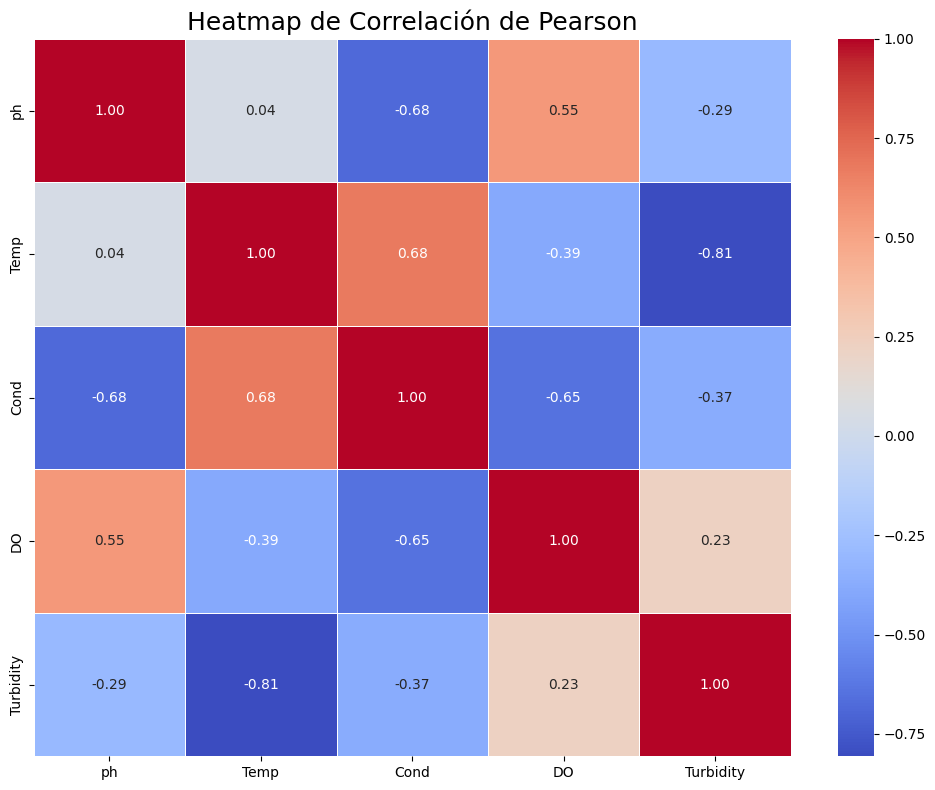

In [17]:
# --- Cálculo de la Matriz de Correlación ---
matriz_correlacion = df_numerico.corr()

# --- Visualización del Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacion, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f',
    linewidths=.5
)
plt.title('Heatmap de Correlación de Pearson', fontsize=18)
plt.tight_layout()
plt.show()

### Información Mutua (MI)

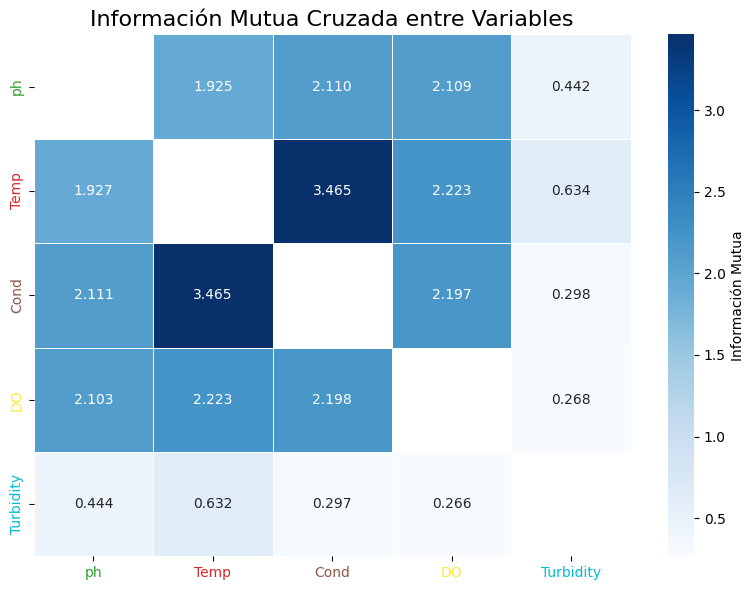

In [ ]:
from itertools import combinations

# --- Cálculo de la Información Mutua Cruzada entre Todas las Variables ---

# Definir paleta de colores personalizada para las variables
colores = {
    'Temp': '#d62728',      # rojo
    'ph': '#2ca02c',        # verde
    'Cond': '#8c564b',      # café
    'DO': '#ffeb3b',        # amarillo
    'Turbidity': '#00bcd4'  # celeste
}

# Inicializar matriz vacía
mi_matrix = pd.DataFrame(
    np.zeros((len(columnas_numericas), len(columnas_numericas))),
    columns=columnas_numericas,
    index=columnas_numericas
)

# Calcular MI cruzada (simétrica)
for i, col1 in enumerate(columnas_numericas):
    for j, col2 in enumerate(columnas_numericas):
        if i == j:
            mi_matrix.loc[col1, col2] = np.nan 
        else:
            mi = mutual_info_regression(
                df_numerico[[col1]], df_numerico[col2], random_state=42
            )[0]
            mi_matrix.loc[col1, col2] = mi

# Visualización del heatmap con colores personalizados en etiquetas
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    mi_matrix,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    linewidths=.5,
    cbar_kws={'label': 'Información Mutua'}
)

# Cambiar color de las etiquetas de los ejes
for label in ax.get_xticklabels():
    var = label.get_text()
    label.set_color(colores.get(var, 'black'))
for label in ax.get_yticklabels():
    var = label.get_text()
    label.set_color(colores.get(var, 'black'))

plt.title('Información Mutua Cruzada entre Variables', fontsize=16)
plt.tight_layout()
plt.show()

### Transfer Entropy (TE)

#### Cálculo de TE

In [ ]:
# --- 1. Configuración del Análisis ---
K_HISTORY = 4
N_BINS = 4
P_VALUE_THRESHOLD = 0.05

# --- 2. Función para Calcular TE con Significancia ---
def calculate_significance(source: np.ndarray, target: np.ndarray, k: int, n_permutations: int = 100) -> tuple[float, float]:
    if len(source) != len(target) or len(source) < k:
        return 0.0, 1.0
    real_te = pyinform.transfer_entropy(source, target, k=k)
    surrogate_tes = np.array([
        pyinform.transfer_entropy(np.random.permutation(source), target, k=k)
        for _ in range(n_permutations)
    ])
    p_value = (np.sum(surrogate_tes >= real_te) + 1) / (n_permutations + 1)
    return real_te, p_value

# --- 3. Discretización de los Datos (Binning) ---
print(f"Discretizando los datos en {N_BINS} bins...")
df_binned = pd.DataFrame()
for col in columnas_numericas:
    df_binned[col] = pd.qcut(df_numerico[col], q=N_BINS, labels=False, duplicates='drop')

# --- 4. Cálculo de la Entropía de Transferencia Cruzada entre Todas las Variables ---
te_matrix = pd.DataFrame(np.nan, index=columnas_numericas, columns=columnas_numericas)

print(f"Calculando TE cruzada para todas las variables (historial k={K_HISTORY})...")
for source in columnas_numericas:
    for target in columnas_numericas:
        if source != target:
            source_series = df_binned[source].values
            target_series = df_binned[target].values
            te, p = calculate_significance(source_series, target_series, k=K_HISTORY)
            te_matrix.loc[source, target] = te if p < P_VALUE_THRESHOLD else np.nan

print("\nMatriz de Entropía de Transferencia Significativa (p < 0.05):")
display(te_matrix)


Discretizando los datos en 4 bins...
Calculando TE cruzada para todas las variables (historial k=4)...

Matriz de Entropía de Transferencia Significativa (p < 0.05):


,ph,Temp,Cond,DO,Turbidity
ph,NaN,0.002413,0.002597,NaN,0.087833
Temp,NaN,NaN,0.002594,NaN,0.083706
Cond,NaN,0.002364,NaN,0.00931,0.076544
DO,NaN,NaN,NaN,NaN,0.075629
Turbidity,NaN,NaN,NaN,0.00847,NaN


#### Visualizar TE

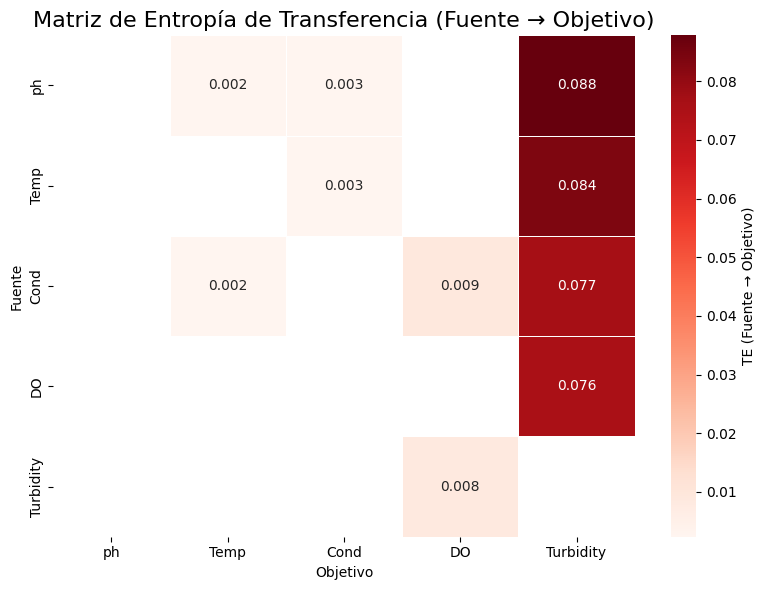

In [ ]:
from itertools import product

# --- 1. Inicializar matrices vacías ---
te_matrix = pd.DataFrame(
    np.nan,
    index=columnas_numericas,
    columns=columnas_numericas
)
te_matrix_rev = pd.DataFrame(
    np.nan,
    index=columnas_numericas,
    columns=columnas_numericas
)

# --- 2. Calcular TE cruzada para todos los pares (i ≠ j) ---
for source, target in product(columnas_numericas, repeat=2):
    if source != target:
        source_series = df_binned[source].values
        target_series = df_binned[target].values
        te, p = calculate_significance(source_series, target_series, k=K_HISTORY)
        te_rev, p_rev = calculate_significance(target_series, source_series, k=K_HISTORY)
        te_matrix.loc[source, target] = te if p < P_VALUE_THRESHOLD else np.nan
        te_matrix_rev.loc[target, source] = te_rev if p_rev < P_VALUE_THRESHOLD else np.nan

# --- 3. Visualización de la matriz TE (fuente → objetivo) ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    te_matrix,
    annot=True,
    fmt=".3f",
    cmap="Reds",
    linewidths=.5,
    cbar_kws={'label': 'TE (Fuente → Objetivo)'}
)
plt.title('Matriz de Entropía de Transferencia (Fuente → Objetivo)', fontsize=16)
plt.xlabel('Objetivo')
plt.ylabel('Fuente')
plt.tight_layout()
plt.show()
